In [1]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.middle = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )
        
        self.final = nn.Conv2d(64, out_channels, kernel_size=1)
        
    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.middle(x1)
        x3 = self.decoder(x2)
        x4 = self.final(x3)
        return x4


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
import os
import numpy as np
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

class CustomDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg') or f.endswith('.png')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.image_files[idx])
        img = Image.open(img_path).convert('RGB')

        label_path = os.path.join(self.label_dir, self.image_files[idx].replace('.jpg', '.npy'))
        label = np.load(label_path)
        label = label[:, :, 0] // 255  # Convert pixel values to class indices (0 or 1)

        if self.transform:
            img = self.transform(img)

        return img, torch.from_numpy(label).long()


In [3]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Set device to GPU if available
device = torch.device("mps")

# Create dataset and data loader
train_dataset = CustomDataset('dataset/images/train/', 'dataset/labels/train/', transform=ToTensor())
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

val_dataset = CustomDataset('dataset/images/val/', 'dataset/labels/val/', transform=ToTensor())
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# Create the UNet model
model = UNet(in_channels=3, out_channels=2).to(device)  # Added .to(device)


In [4]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train and validate the model
num_epochs = 5

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)  # Move data and target to GPU
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)  # Move data and target to GPU
            output = model(data)
            loss = criterion(output, target)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Epoch 1/5, Train Loss: 0.2869, Validation Loss: 0.2503
Epoch 2/5, Train Loss: 0.2361, Validation Loss: 0.2369
Epoch 3/5, Train Loss: 0.2402, Validation Loss: 0.2413
Epoch 4/5, Train Loss: 0.2255, Validation Loss: 0.2371
Epoch 5/5, Train Loss: 0.2264, Validation Loss: 0.2575


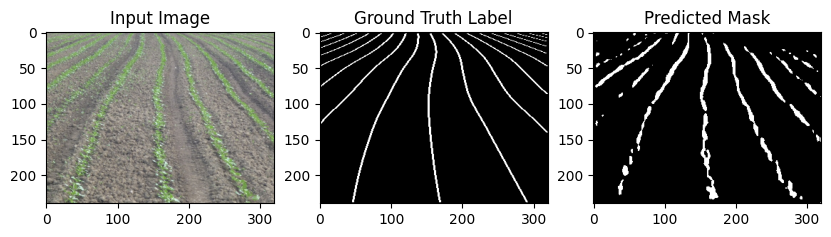

In [24]:
import matplotlib.pyplot as plt

# Load a single image and its corresponding label
img_path = 'dataset/images/val/crop_row_226.jpg'
label_path = 'dataset/labels/val/crop_row_226.npy'
img = Image.open(img_path).convert('RGB')
label = np.load(label_path)[:, :, 0] // 255

# Preprocess the image and run it through the model
img_tensor = ToTensor()(img).unsqueeze(0).to(device)
output = model(img_tensor).squeeze(0)
output = output.cpu().detach().numpy()[1,:,:]
output_scaled = (output-output.min())/(output.max()-output.min())
output = np.where(output_scaled > 0.8, 0, 1)

# Plot the input image, label, and predicted mask
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title('Input Image')
axs[1].imshow(label, cmap='gray')
axs[1].set_title('Ground Truth Label')
axs[2].imshow(output, cmap='binary')
axs[2].set_title('Predicted Mask')
plt.show()

In [25]:
overlap = label*output
union = label+output
IOU = overlap.sum()/float(union.sum())
print(IOU)

0.03847785170850675
